In [2]:
#Standard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#AIF360 Dataset Classes 
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset

#AIF360 Metrics Classes  
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import ClassificationMetric

#AIF360 Algorithms 
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing
# AI360 Explainers
from aif360.explainers import MetricTextExplainer

#Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score


#Tensorflow -- install version before 2.0
import tensorflow as tf 

#For Markdown
from IPython.display import Markdown, display

#Helper Functions
from src.classifier_functions import *
from src.dataset_functions import *
from src.fair_classifier_functions import *


//anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Creating the Datasets to Analyze with AIF 360

In [3]:
data = create_multiple_datasets(create_binary_dataset_salary, [150000, 200000])

In [4]:
train, val, test = create_split_lists(data)

In [5]:
train_mean, train_di = get_dataset_metrics_list(train)

In [6]:
val_mean, val_di = get_dataset_metrics_list(val)

In [7]:
## Getting the Initial Metrics between the Training Set and the Validation Set

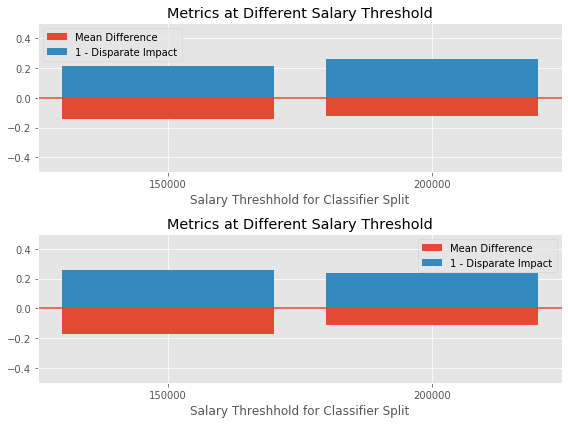

In [8]:
plot_mean_diff_and_di(train_mean, train_di, val_mean, val_di, 'images/initial_metrics.png')

## Creating Predictions from a Random Forest Classifier 

In [9]:
#Excluding Sex as a category on 150,000 Salary Threshold
train_no_gender = train[0].convert_to_dataframe()[0].drop(labels='sex', axis=1)
val_no_gender = val[0].convert_to_dataframe()[0].drop(labels='sex', axis=1)

rf_no_gender = RandomForestClassifier(n_estimators=500, max_depth=5)



In [10]:
X_train = train_no_gender.values[:,0:-1]
y_train = train_no_gender.values[:,-1]
X_test = val_no_gender.values[:,0:-1]
y_test = val_no_gender.values[:,-1]

In [11]:
rf_no_gender.fit(X_train, y_train)
no_gender_preds = rf_no_gender.predict(X_test)

scorecard(y_test, no_gender_preds)

The Accuracy score is 0.776.

The Precision score is 0.732.

The Recall score is 0.999.

      Confusion Matrix


,Actual True,Actual False
Predicted True,976,357
Predicted False,1,266


In [12]:
add_gender = val[0].copy()
add_gender.labels = no_gender_preds

In [14]:
get_dataset_metrics_list([add_gender])

([-0.23639779546601514], [0.25641845566834864])

In [17]:
get_dataset_metrics_list([val[0]])

([-0.1731798354094527], [0.25630615640598997])

In [19]:
## Including Sex as a category
pred_list = get_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), 
                train, val)

In [20]:
pred_mean, pred_di = get_dataset_metrics_list(pred_list)

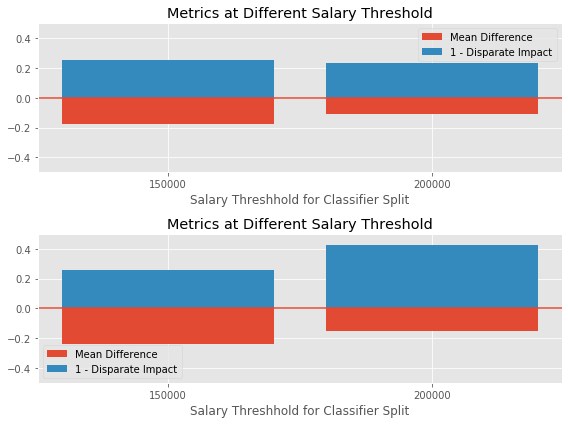

In [21]:
plot_mean_diff_and_di(val_mean, val_di, pred_mean, pred_di, 'images/initial_rf_metrics.png')

## Reweighing to Reduce Bias

In [22]:
privileged_groups= [{'sex':1}]
unprivileged_groups= [{'sex': 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups, 
               privileged_groups=privileged_groups)

rw_train_datasets = []
for dataset in train: 
    rw = RW.fit_transform(dataset)
    rw_train_datasets.append(rw)
    
rw_val_datasets = [] 
for dataset in val: 
    rw = RW.fit_transform(dataset)
    rw_val_datasets.append(rw)

In [23]:
rw_train_mean, rw_train_di = get_dataset_metrics_list(rw_train_datasets)
rw_val_mean, rw_val_di = get_dataset_metrics_list(rw_val_datasets)


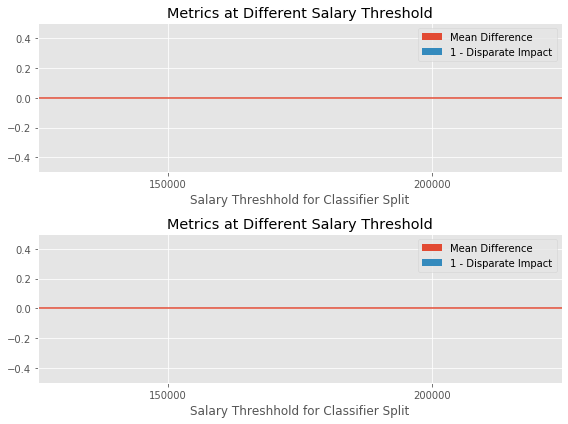

In [24]:
plot_mean_diff_and_di(rw_train_mean, rw_train_di, rw_val_mean, rw_val_di, 'images/rw_metrics.png')

### New Predictions with Reweighted Random Forest

In [25]:
rw_pred_list = get_rw_predictions(RandomForestClassifier(n_estimators=500, max_depth=5), rw_train_datasets, rw_val_datasets)

In [26]:
rw_pred_mean, rw_pred_di = get_dataset_metrics_list(rw_pred_list)

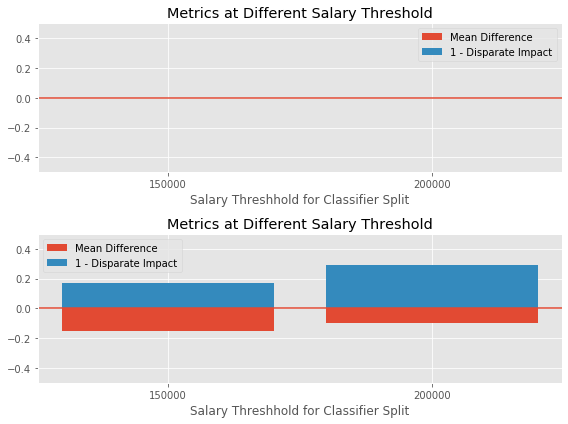

In [27]:
plot_mean_diff_and_di(rw_val_mean, rw_val_di, rw_pred_mean, rw_pred_di, 'images/rw_rf_metrics.png')

### Inprocessing with Adversarial Debiasing 

In [28]:
#sess.close()
tf.reset_default_graph()
sess = tf.Session()

In [29]:
##Creating Tensorflow Session - must not use Tensorflow 2.0 
sess = tf.Session()
db_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                            num_epochs  = 100,
                            batch_size = 50,
                            adversary_loss_weight = .1,     
                            debias=True,
                          sess=sess)

In [30]:
db_model.fit(train[0]) 




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





epoch 0; iter: 0; batch classifier loss: 0.687756; batch adversarial loss: 0.699977
epoch 1; iter: 0; batch classifier loss: 0.522819; batch adversarial loss: 0.671638
epoch 2; iter: 0; batch classifier loss: 0.587038; batch adversarial loss: 0.693643
epoch 3; iter: 0; batch classifier loss: 0.417243; batch adversarial loss: 0.656453
epoch 4; iter: 0; batch classifier loss: 0.537116; batch adversarial loss: 0.704800

In [31]:
adb_preds_1 = db_model.predict(val[0])

In [32]:
sess.close()
tf.reset_default_graph()
sess = tf.Session()
db_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                            num_epochs  = 100,
                            batch_size = 50,
                            adversary_loss_weight = .1,     
                            debias=True,
                          sess=sess)

db_model.fit(train[1]) 

epoch 0; iter: 0; batch classifier loss: 1.154762; batch adversarial loss: 0.689920
epoch 1; iter: 0; batch classifier loss: 0.626060; batch adversarial loss: 0.696562
epoch 2; iter: 0; batch classifier loss: 0.573802; batch adversarial loss: 0.671605
epoch 3; iter: 0; batch classifier loss: 0.545193; batch adversarial loss: 0.719358
epoch 4; iter: 0; batch classifier loss: 0.968584; batch adversarial loss: 0.693636
epoch 5; iter: 0; batch classifier loss: 0.527650; batch adversarial loss: 0.631732
epoch 6; iter: 0; batch classifier loss: 0.553207; batch adversarial loss: 0.690571
epoch 7; iter: 0; batch classifier loss: 0.579226; batch adversarial loss: 0.615036
epoch 8; iter: 0; batch classifier loss: 0.592185; batch adversarial loss: 0.658181
epoch 9; iter: 0; batch classifier loss: 0.674065; batch adversarial loss: 0.632453
epoch 10; iter: 0; batch classifier loss: 0.627059; batch adversarial loss: 0.632712
epoch 11; iter: 0; batch classifier loss: 0.576074; batch adversarial loss:

In [33]:
adb_preds_2 = db_model.predict(val[1])


In [34]:
adb_preds = [adb_preds_1, adb_preds_2]

In [35]:
adb_mean, adb_di = get_dataset_metrics_list(adb_preds)


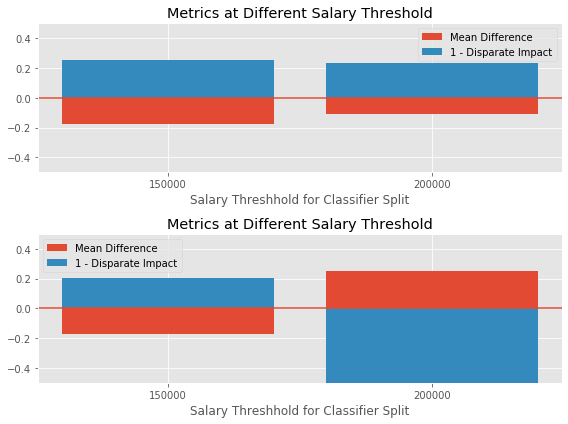

In [36]:
plot_mean_diff_and_di(val_mean, val_di, adb_mean, adb_di, 'images/adb_metrics.png')

## Inprocessing PrejudiceRemover

In [37]:
pr = PrejudiceRemover(sensitive_attr='sex', class_attr='salary')
pr.fit(train[0])
pr2 = PrejudiceRemover(sensitive_attr='sex', class_attr='salary')
pr2.fit(train[1])

In [38]:
pr_preds_1 = pr.predict(val[0])
pr_preds_2 = pr2.predict(val[1])
pr_preds = [pr_preds_1, pr_preds_2]


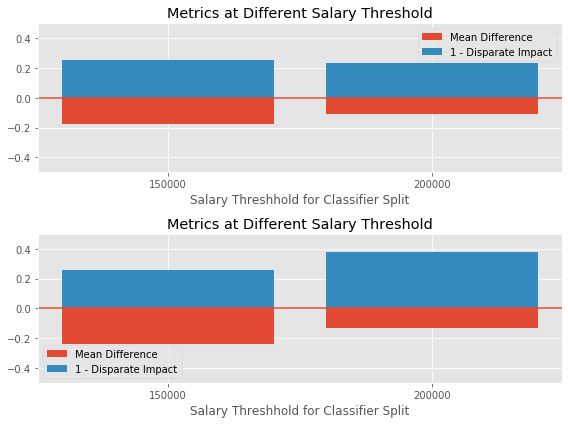

In [39]:
pr_mean, pr_di = get_dataset_metrics_list(pr_preds)
plot_mean_diff_and_di(val_mean, val_di, pr_mean, pr_di, 'images/pr_metrics.png')

### PostProcessing with Calibrated Odd Postprocessing

#### With Random Forest Predictions

In [40]:
cpp_rf = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')
cpp2_rf= CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')

cpp_rf.fit(val[0], pred_list[0])
cpp2_rf.fit(val[1], pred_list[1])

In [41]:
cpp_preds_rf_1 = cpp_rf.predict(pred_list[0])
cpp_preds_rf_2 = cpp2_rf.predict(pred_list[1])
cpp_rf_preds = [cpp_preds_rf_1, cpp_preds_rf_2]


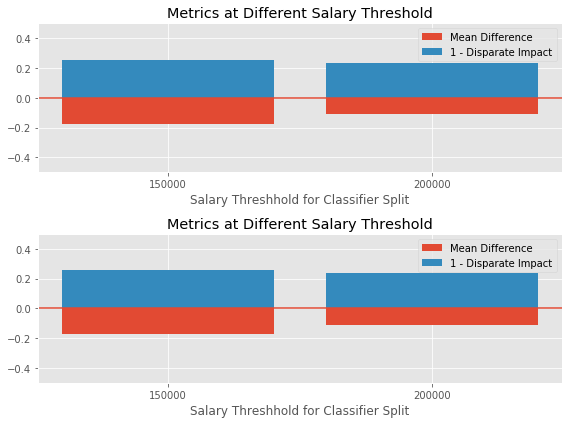

In [42]:
cpp_rf_mean, cpp_rf_di = get_dataset_metrics_list(cpp_rf_preds)
plot_mean_diff_and_di(val_mean, val_di, cpp_rf_mean, cpp_rf_di, 'images/cpp_rf_metrics.png')

#### With Adversarial Debiasing Predictions 


In [43]:
cpp_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')
cpp2_adb = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint='weighted')

cpp_adb.fit(val[0],adb_preds[0])
cpp2_adb.fit(val[1], adb_preds[1])

In [44]:
cpp_preds_adb_1 = cpp_adb.predict(adb_preds[0])
cpp_preds_adb_2 = cpp2_adb.predict(adb_preds[1])
cpp_adb_preds = [cpp_preds_adb_1, cpp_preds_adb_2]

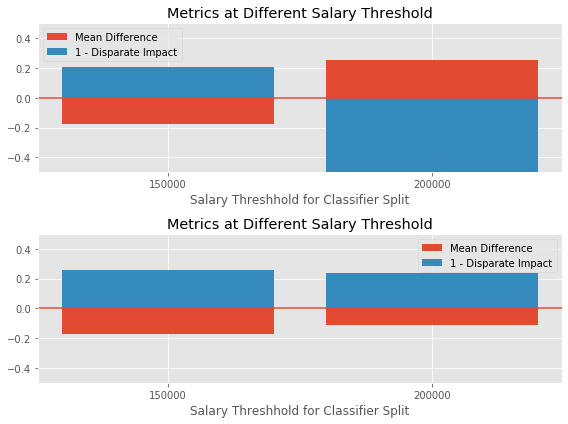

In [45]:
cpp_adb_mean, cpp_adb_di = get_dataset_metrics_list(cpp_adb_preds)
plot_mean_diff_and_di(adb_mean, adb_di, cpp_adb_mean, cpp_adb_di, 'images/cpp_adb_metrics.png')

### Reviewing the Overall Metrics to Choose the Best Model

In [46]:
rf_metrics = get_classifier_metrics(val, pred_list)
rf_rw_metrics = get_classifier_metrics(rw_val_datasets, rw_pred_list)
adb_metrics = get_classifier_metrics(val, adb_preds)
pr_metrics = get_classifier_metrics(val, pr_preds)
cpp_rf_metrics = get_classifier_metrics(val, cpp_rf_preds)
cpp_adb_metrics = get_classifier_metrics(val, cpp_adb_preds)


In [47]:
results_150 = {'Random Forest': np.array(rf_metrics)[:,0],
                'Reweighted Random Forest':np.array(rf_rw_metrics)[:,0],
                'Adversarial Debiasing':np.array(adb_metrics)[:,0], 
                'Prejudice Remover':np.array(pr_metrics)[:,0] ,
                'Post-Proc Random Forest':np.array(cpp_rf_metrics)[:,0], 
               'Post-Proc Adversarial Debiasing':np.array(cpp_adb_metrics)[:,0]}

results_200 = {'Random Forest': np.array(rf_metrics)[:,1],
                'Reweighted Random Forest':np.array(rf_rw_metrics)[:,1],
                'Adversarial Debiasing':np.array(adb_metrics)[:,1], 
                'Prejudice Remover':np.array(pr_metrics)[:,1] ,
                'Post-Proc Random Forest':np.array(cpp_rf_metrics)[:,1], 
               'Post-Proc Adversarial Debiasing':np.array(cpp_adb_metrics)[:,1]}

In [48]:
#np.array([pred_mean[0], rw_pred_mean[0], adb_mean[0], pr_mean[0], cpp_rf_mean[0], cpp_adb_mean[0])
results_150_df = pd.DataFrame.from_dict(results_150, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference']) 
results_200_df = pd.DataFrame.from_dict(results_200, orient='index', columns=['Accuracy', 'Balanced Accuracy', 'Average Odds Difference', 'Equal Opporunity Difference', 'Precision Difference'])

results_150_df.insert(loc=0, column = 'Mean Difference', value = [pred_mean[0], rw_pred_mean[0], adb_mean[0], pr_mean[0], cpp_rf_mean[0], cpp_adb_mean[0]])
results_200_df.insert(loc=0, column = 'Mean Difference', value = [pred_mean[1], rw_pred_mean[1], adb_mean[1], pr_mean[1], cpp_rf_mean[1], cpp_adb_mean[1]])

results_150_df.insert(loc=1, column = '1-Disparate Impact', value = [pred_di[0], rw_pred_di[0], adb_di[0], pr_di[0], cpp_rf_di[0], cpp_adb_di[0]])
results_200_df.insert(loc=1, column = '1-Disparate Impact', value = [pred_di[1], rw_pred_di[1], adb_di[1], pr_di[1], cpp_rf_di[1], cpp_adb_di[1]])




In [49]:
display(Markdown("#### Predicting Salary > 150,000 Model"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[0], train_di[0]))
print('Original Validation Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(val_mean[0], val_di[0]))
results_150_df

#### Predicting Salary > 150,000 Model

Original Training Mean Difference -0.144 and 1-Disparate Impact 0.217 

Original Validation Mean Difference -0.173 and 1-Disparate Impact 0.256 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Random Forest,-0.239063,0.259028,0.776,0.713,-0.199,-0.003,0.000
Reweighted Random Forest,-0.153590,0.169252,0.761,0.693,-0.197,0.000,0.137
Adversarial Debiasing,-0.175337,0.203676,0.757,0.701,-0.139,0.070,0.003
Prejudice Remover,-0.238062,0.258223,0.777,0.714,-0.197,-0.003,-0.001
Post-Proc Random Forest,-0.173180,0.256306,1.000,1.000,0.000,0.000,0.000
Post-Proc Adversarial Debiasing,-0.173180,0.256306,1.000,1.000,0.000,0.000,0.000


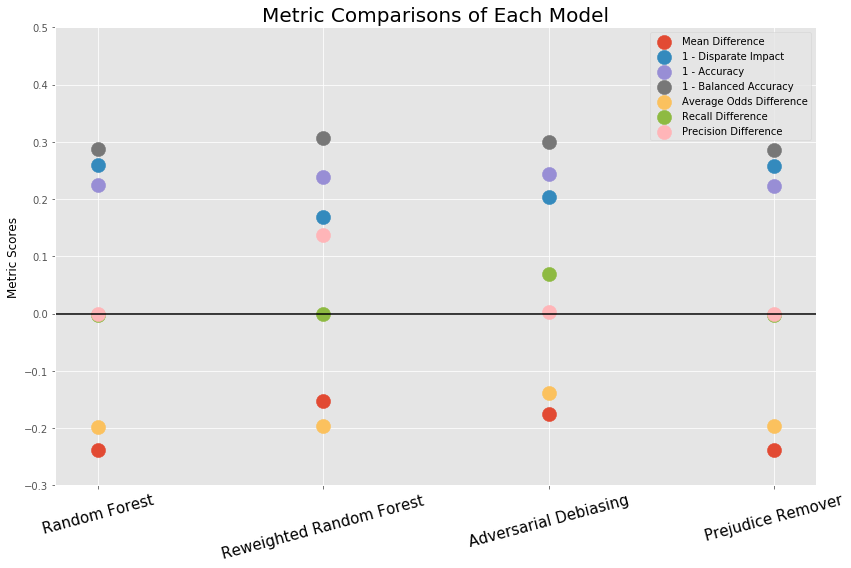

In [81]:
fig, ax = plt.subplots(figsize = (12,8))
x_axis = np.linspace(0,3,4)


ax.scatter(x_axis, results_150_df.iloc[0:4,0].values, label='Mean Difference', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,1].values, label='1 - Disparate Impact', s=200 )
ax.scatter(x_axis, 1 - results_150_df.iloc[0:4,2].values, label='1 - Accuracy', s=200 )
ax.scatter(x_axis, 1- results_150_df.iloc[0:4,3].values, label='1 - Balanced Accuracy', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,4].values, label='Average Odds Difference', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,5].values, label='Recall Difference', s=200 )
ax.scatter(x_axis, results_150_df.iloc[0:4,6].values, label='Precision Difference', s=200 )

ax.axhline(0, color='black')
ax.set_xticks(x_axis)
ax.set_xticklabels(results_150_df.index, rotation=15, color='black', size=15 )
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')

ax.legend(loc='upper right')
ax.set_ylim(-.3, .5)
ax.set_ylabel('Metric Scores', color = 'black')
ax.set_title('Metric Comparisons of Each Model',size=20)
plt.tight_layout()
plt.savefig('images/model_150_metrics_v2')

In [51]:
display(Markdown("#### Predicting Salary > 200,000 Models"))
print('Original Training Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(train_mean[1], train_di[1]))
print('Original Validation Mean Difference {:2.3f} and 1-Disparate Impact {:2.3f} \n'.format(val_mean[1], val_di[1]))
results_200_df

#### Predicting Salary > 200,000 Models

Original Training Mean Difference -0.125 and 1-Disparate Impact 0.262 

Original Validation Mean Difference -0.112 and 1-Disparate Impact 0.235 



,Mean Difference,1-Disparate Impact,Accuracy,Balanced Accuracy,Average Odds Difference,Equal Opporunity Difference,Precision Difference
Random Forest,-0.153271,0.428103,0.661,0.638,-0.116,-0.076,0.081
Reweighted Random Forest,-0.098800,0.293338,0.655,0.632,-0.093,-0.045,0.169
Adversarial Debiasing,0.251889,-0.768810,0.638,0.629,0.305,0.413,-0.104
Prejudice Remover,-0.134919,0.378852,0.660,0.638,-0.094,-0.040,0.082
Post-Proc Random Forest,-0.111981,0.235361,1.000,1.000,0.000,0.000,0.000
Post-Proc Adversarial Debiasing,-0.111981,0.235361,1.000,1.000,0.000,0.000,0.000


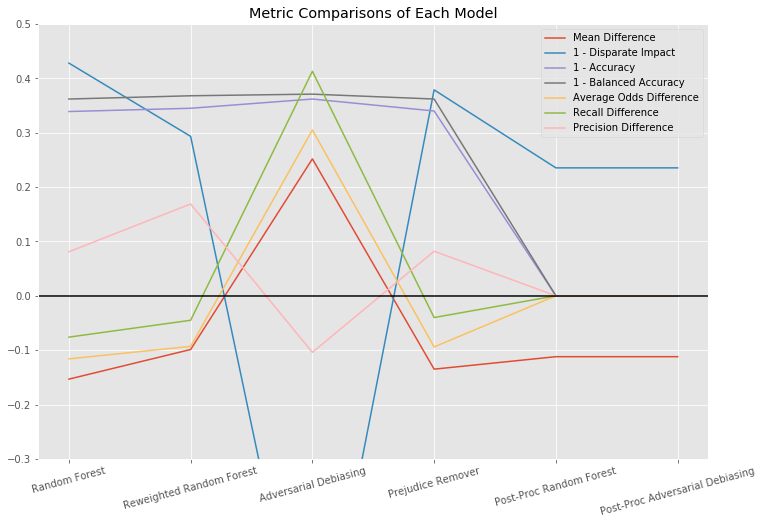

In [52]:
fig, ax = plt.subplots(figsize = (12,8))
x_axis = np.linspace(0,5,6)


ax.plot(x_axis, results_200_df.iloc[:,0].values, label='Mean Difference' )
ax.plot(x_axis, results_200_df.iloc[:,1].values, label='1 - Disparate Impact' )
ax.plot(x_axis, 1 - results_200_df.iloc[:,2].values, label='1 - Accuracy' )
ax.plot(x_axis, 1- results_200_df.iloc[:,3].values, label='1 - Balanced Accuracy' )
ax.plot(x_axis, results_200_df.iloc[:,4].values, label='Average Odds Difference' )
ax.plot(x_axis, results_200_df.iloc[:,5].values, label='Recall Difference' )
ax.plot(x_axis, results_200_df.iloc[:,6].values, label='Precision Difference' )

ax.axhline(0, color='black')
ax.set_xticks(x_axis)
ax.set_xticklabels(results_200_df.index, rotation=15 )
# ax.set_title('Dataset Metrics at Different Salary Threshold')
# ax.set_xlabel('Salary Threshhold for Classifier Split')

ax.legend(loc='upper right')
ax.set_ylim(-.3, .5)
ax.set_title('Metric Comparisons of Each Model')
plt.savefig('images/model_200_metrics')

In [63]:
#Baseline
priv, unpriv = get_confusion_matrix(val[0], val[0])

Confusion Matrix for Men {'TP': 675.0, 'FP': 0.0, 'TN': 324.0, 'FN': 0.0}
Confusion Matrix for Women {'TP': 302.0, 'FP': 0.0, 'TN': 299.0, 'FN': 0.0}


In [64]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(priv)


Confusion Matrix for Men


,Actual True,Actual False
Predicted True,675.0,0.0
Predicted False,0.0,324.0


In [65]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,302.0,0.0
Predicted False,0.0,299.0


In [66]:
rf_priv, rf_unpriv = get_confusion_matrix(val[0], pred_list[0])

Confusion Matrix for Men {'TP': 675.0, 'FP': 247.0, 'TN': 77.0, 'FN': 0.0}
Confusion Matrix for Women {'TP': 301.0, 'FP': 110.0, 'TN': 189.0, 'FN': 1.0}


In [67]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(rf_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,675.0,247.0
Predicted False,0.0,77.0


In [68]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(rf_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,301.0,110.0
Predicted False,1.0,189.0


In [69]:
rf_rw_priv, rf_rw_unpriv = get_confusion_matrix(rw_val_datasets[0], rw_pred_list[0])

Confusion Matrix for Men {'TP': 610.0143749999999, 'FP': 296.54151041666665, 'TN': 92.44411458333339, 'FN': 0.0}
Confusion Matrix for Women {'TP': 366.98562499999997, 'FP': 86.09224498327761, 'TN': 147.92213001672243, 'FN': 0.0}


In [70]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(rf_rw_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,610.0,297.0
Predicted False,0.0,92.0


In [71]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(rf_rw_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,367.0,86.0
Predicted False,0.0,148.0


In [72]:
adb_priv, adb_unpriv = get_confusion_matrix(val[0], adb_preds[0])

Confusion Matrix for Men {'TP': 628.0, 'FP': 232.0, 'TN': 92.0, 'FN': 47.0}
Confusion Matrix for Women {'TP': 302.0, 'FP': 110.0, 'TN': 189.0, 'FN': 0.0}


In [73]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(adb_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,628.0,232.0
Predicted False,47.0,92.0


In [74]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(adb_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,302.0,110.0
Predicted False,0.0,189.0


In [75]:
pr_priv, pr_unpriv = get_confusion_matrix(val[0], pr_preds[0])

Confusion Matrix for Men {'TP': 675.0, 'FP': 246.0, 'TN': 78.0, 'FN': 0.0}
Confusion Matrix for Women {'TP': 301.0, 'FP': 110.0, 'TN': 189.0, 'FN': 1.0}


In [76]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(pr_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,675.0,246.0
Predicted False,0.0,78.0


In [156]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(pr_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,311.0,98.0
Predicted False,1.0,185.0


In [126]:
cpp_rf_priv, cpp_rf_unpriv = get_confusion_matrix(val[0], cpp_rf_preds[0])

Confusion Matrix for Men {'TP': 664.0, 'FP': 0.0, 'TN': 341.0, 'FN': 0.0}
Confusion Matrix for Women {'TP': 312.0, 'FP': 0.0, 'TN': 283.0, 'FN': 0.0}


In [127]:
print('Confusion Matrix for Men')
confusion_matrix_to_df_from_dict(cpp_rf_priv)

Confusion Matrix for Men


,Actual True,Actual False
Predicted True,664.0,0.0
Predicted False,0.0,341.0


In [128]:
print('Confusion Matrix for Women')
confusion_matrix_to_df_from_dict(cpp_rf_unpriv)

Confusion Matrix for Women


,Actual True,Actual False
Predicted True,312.0,0.0
Predicted False,0.0,283.0
